# Harmonisation strategies
Now the we have seen how different scanners can produce difference in images between the same individual on different scanners, we need to figure out to account for this data. 

In [1]:
import os
import nest_asyncio
nest_asyncio.apply()
import numpy as np
import pandas as pd
import datalad.api as dl

Let's grab the dataset that has all the imgaging volumes for the study and read it into memory

In [ ]:
dl_source='https://github.com/HealthBioscienceIDEAS/demon-imaging-data.git'
sample=dl.clone(dl_source,path='/tmp/sample',description='Cloned sample dataset for import')
sample.update(merge=True)
sample.siblings(action='enable',name='demons-data')
in_file=sample.get('./GENFI_DEMON_SPREADSHEET.xlsx')

[INFO] Fetching updates for Dataset(/tmp/sample) 


.: demons-data(?) [git]


In [3]:
df_xsec=pd.read_excel(in_file[0]['path'])
df_xsec['Sex']=pd.Categorical(df_xsec['Sex'],categories=[0,1])
df_xsec['Sex']=df_xsec['Sex'].cat.rename_categories(['Female','Male'])
df_xsec['Site'] = pd.Categorical(df_xsec['Site'],categories=np.arange(23))
df_xsec['Group']=pd.Categorical(df_xsec['Group'],categories=[0,1,2])
df_xsec['Group']=df_xsec['Group'].cat.rename_categories(['Non-carrier','Presymptomatic','Symptomatic'])

A quick cross tab to show the different kinds of scanners used at each site. Somethings to notice:
* Some sites have a lot more data than others. The largest site has 143 scans while the smallest has 2.
* Out of the 22 sites, there are only 7 scanner models being used.
* Some sites have switched scanners midway through the study (See Site 8).

In [5]:
pd.crosstab(df_xsec['Site'],df_xsec['Scanner'])

Scanner,GE 1.5T,GE 3T,Philips 3T,Siemens 1.5T,Siemens Prisma 3T,Siemens Skyra 3T,Siemens Trio 3T
Site,,,,,,,
0,0,0,0,0,0,8,20
1,0,0,45,0,0,0,0
2,0,0,0,0,3,0,0
3,0,0,143,0,0,0,0
4,0,0,3,0,0,0,0
5,0,25,0,0,6,0,0
6,0,0,18,0,0,0,0
7,0,0,0,0,10,0,12
8,0,0,0,33,0,36,0


## Analysis
Now that we have the data,we have three groups. Let's take a look at a couple of structures and see what edifferences they are.
### Simple regression no sites
We will compare the groups using sex, age, and TIV only as covariates.

In [6]:
df_xsec.groupby("Group").agg(
    {
        "Age": ["mean", "std", "min", "max" ],
        "EYO": ["mean", "std", "min", "max" ],
        "TIV": ["mean", "std", "min", "max" ]
    }
).style.format('{0:,.2f}')

### Checking for site differences
Are their differences in site or scanner that are occuring in this data. Let's run the same analysis again including them as a covariate. For this, we are going to use the package statsmodels

In [7]:
import statsmodels.api as stats
import statsmodels.formula.api as statsfx

If youa re familiar with R, the regression equations in statsmodels are setup in a similar fashion. So the first model will take into account age, sex, and TIV< but *not* site. We will center age and TIV so that the intercept makes more sense.

In [8]:
df_xsec=df_xsec.dropna(subset=["Group","Age","Sex","TIV"])
df_xsec["Age_centered"]=df_xsec['Age']-df_xsec['Age'].mean()
df_xsec["TIV_centered"]=df_xsec['TIV']-df_xsec['TIV'].mean()
results= statsfx.ols('Insula_volume ~ Group + Age_centered + Sex + TIV_centered',data=df_xsec).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Insula_volume   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     303.5
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          1.72e-163
Time:                        14:49:56   Log-Likelihood:                -5109.0
No. Observations:                 622   AIC:                         1.023e+04
Df Residuals:                     616   BIC:                         1.026e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

### Interpretation
Let's look at the results from the regression output:
* The average Insular volume for a female non-carrier of average age (~48 years in this cohort) and average TIV(1420 ml) is 10730mm$^3$. 
* Female presymptomatic carriers of a similar age and TIV have 233mm$^3$ less volume than the non carriers
* Female symptomatic carriers of a similar age and TIV have 2147mm$^3$ less. These differences are both significantly differetn from zero. 
* While there is no significant evidence that the difference between sexes is significant, There are clear age and TIV related differences with every 1000mm$^3$(or 1ml) of TIV resulting in an insual that is 6mm$^3$ bigger, and for every year, there is a loss of 41mm$^3$.

Before we go on, let's take a look and see if we can show differences in individuals in site. We will plot the predicted values along the site axis to see if there are differences.

<AxesSubplot:title={'center':'predicted'}, xlabel='[Site]'>

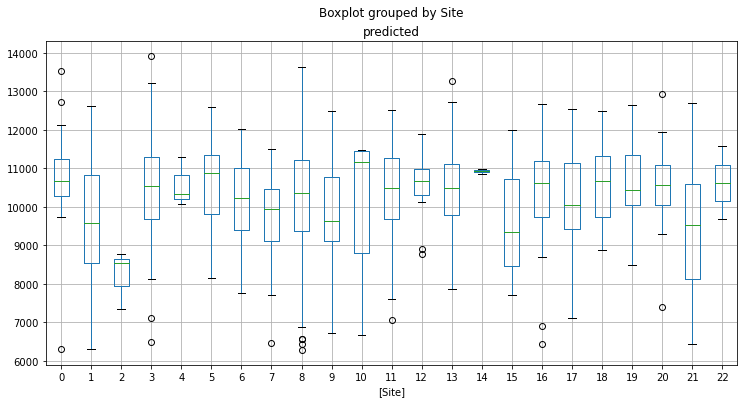

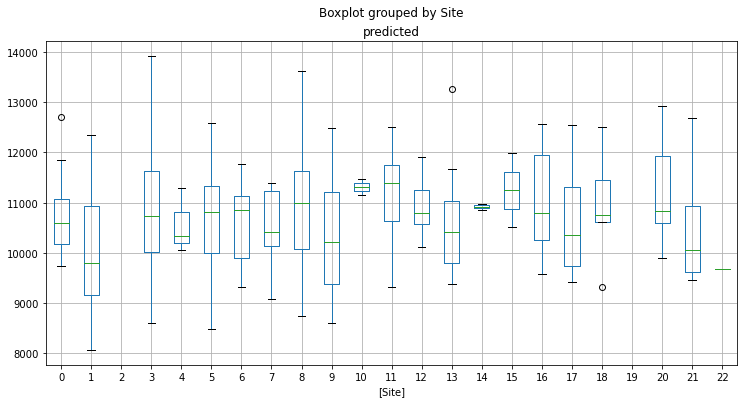

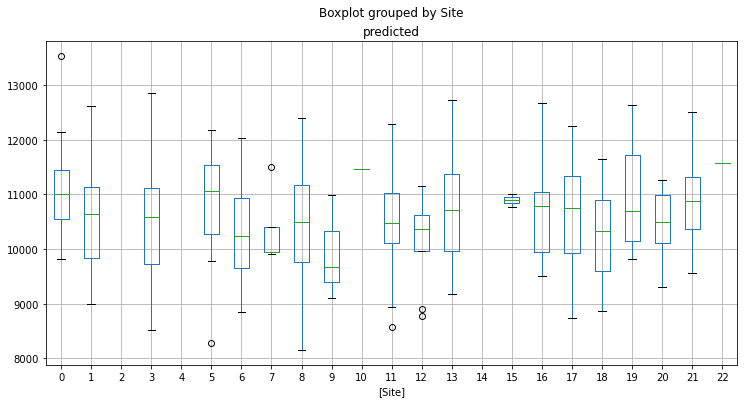

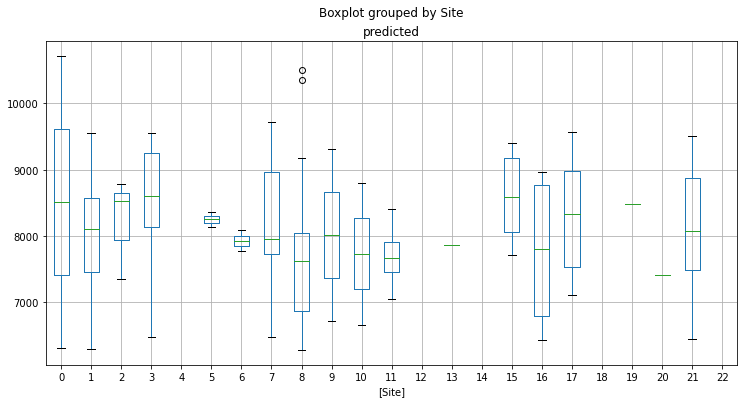

In [9]:
df_xsec['predicted'] = results.predict()
df_xsec.boxplot('predicted',by=['Site'],figsize=(12,6))
df_nc=df_xsec.query('Group =="Non-carrier"')
df_nc.boxplot('predicted',by=['Site'],figsize=(12,6))
df_pmc=df_xsec.query('Group =="Presymptomatic"')
df_pmc.boxplot('predicted',by=['Site'],figsize=(12,6))
df_smc=df_xsec.query('Group =="Symptomatic"')
df_smc.boxplot('predicted',by=['Site'],figsize=(12,6))

In general, we can see that the predicted values not only have different mean values, but different amounts of variability as well. There are also some sites that have very low samples, making the abiity to identify their influence difficult by normal means.

## Adding site as a covariate
Now we are going to add the site variable as a covariate to the equation.

In [59]:
site_results= statsfx.ols('Insula_volume ~ Group + Age_centered + Sex + TIV_centered + Site',data=df_xsec).fit()
print(site_results.summary())
table=stats.stats.anova_lm(site_results, typ=2)
print(table)

                            OLS Regression Results                            
Dep. Variable:          Insula_volume   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     60.98
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          7.83e-152
Time:                        16:10:19   Log-Likelihood:                -5082.4
No. Observations:                 622   AIC:                         1.022e+04
Df Residuals:                     594   BIC:                         1.034e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

### Interpretation
Overall the estimates change only slightly:
* The change in the presymptomatic carriers is down from 223 to 208.
* The change in the symptomatic carriers is down from 2147 to 2087
* Age is slightly greater per year, while TIV is unchanged and Sex is still not significant.
* There are a couple of sites: Site 3,5,8 that are significantly different than site 0. Notice that Site 0 is all Siemens 3T, while 3 is Philips 3T, 5 is GE 3T, and 8 is a mix of Siemens 1.5T and Skyra 3T - so different scanners.
* The log likelihood, since these are nested models, suggests that adding site improves the models slightly. The $R^2$ is slightly higher as well.

## Scanner
It could be that this is just a scanner difference rather than what site the data was acquired, and some sites have used more than one scanner. Let's try the model again with scanner only. The primary scanner that the protocol was developed on was a Siemens Trio 3T, so let's use that as our baseline value to see how the other scanners compare.

In [60]:
df_xsec['Scanner_cat'] = pd.Categorical(df_xsec['Scanner'],
                                        categories=['Siemens Trio 3T',
                                                    'Siemens Prisma 3T',
                                                    'Siemens Skyra 3T',
                                                    'Siemens 1.5T',
                                                    'Philips 3T',
                                                    'GE 1.5T',
                                                    'GE 3T'])
scanner_results= statsfx.ols('Insula_volume ~ Group + Age_centered + Sex + TIV_centered + Scanner_cat',data=df_xsec).fit()
print(scanner_results.summary())
table=stats.stats.anova_lm(scanner_results, typ=2)
print(table)

                            OLS Regression Results                            
Dep. Variable:          Insula_volume   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     142.3
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          2.74e-160
Time:                        16:11:50   Log-Likelihood:                -5099.9
No. Observations:                 622   AIC:                         1.022e+04
Df Residuals:                     610   BIC:                         1.028e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

### Interpretation
Compared to the site model, it doesn't seem to improve things as much, although there are clear differences between the different scanners.

## Try your own
Now that you have seen how to setup this anlysis. Try with another structure, as scanner differences may not be universal. Some structures to try would be Frontol_lobe_volume, Total_Brain, or Right_Hippocampus. How do the numbers change? 

### Turning to combat
Now we turn to combat, which is designed to help both with the additive bias **AND** the multiplicative bias (heteroskedasity). This is really helpful, but what if there are difference in standard error between sites, and how can we trust those small sample size in some cells. Let's try this with COMbat instead.
Unlike the pervious regression example, Combat prefers lots of different features, so we will include lots of different volumes here, from the right accumbens (column 10) to the Insula volume (column 32)

In [24]:
df_xsec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 0 to 623
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   ID                           622 non-null    object  
 1   Site                         622 non-null    category
 2   Scanner                      622 non-null    object  
 3   Age                          622 non-null    float64 
 4   Sex                          622 non-null    category
 5   Education                    622 non-null    int64   
 6   EYO                          622 non-null    float64 
 7   Group                        622 non-null    category
 8   MutationType                 622 non-null    object  
 9   TIV                          622 non-null    float64 
 10  Right_Accumbens_Area         622 non-null    float64 
 11  Left_Accumbens_Area          622 non-null    float64 
 12  Right_Amygdala               622 non-null    float64 
 13  Left_

In [40]:
from neuroCombat import neuroCombat
covars=df_xsec.filter(["Age_centered","TIV_centered"])
covars["Group"]=df_xsec['Group'].cat.codes
covars["Sex"]=df_xsec['Sex'].cat.codes
covars["Site"]=df_xsec['Site'].cat.codes
covars=covars[["Group","Age_centered","Sex","TIV_centered","Site"]]
categorical_cols=["Group","Sex"]
batch_col="Site"
data=df_xsec.iloc[:,10:33].to_numpy(copy=True).transpose()
data_combat = neuroCombat(dat=data,
    covars=covars,
    batch_col=batch_col,
    categorical_cols=categorical_cols)


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


So now we have harmonised data, let's run again the results to see what infomration we now get for these volumes.

In [45]:
df_xsec['Harmonised_Insula'] = data_combat["data"][22,:].transpose()
df_xsec[['Insula_volume','Harmonised_Insula']]

,Insula_volume,Harmonised_Insula
0,10354.4,10284.450545
1,8256.9,8283.423487
2,8984.4,8754.335615
3,7597.6,8610.426168
4,7577.4,7286.480917
...,...,...
619,7913.9,7800.701861
620,11170.5,10895.631258
621,9984.2,10120.420354
622,10300.5,10236.830510


In [61]:
harmonised_results= statsfx.ols('Harmonised_Insula ~ Group + Age_centered + Sex + TIV_centered',data=df_xsec).fit()
print(harmonised_results.summary())
harmonised_site_results= statsfx.ols('Harmonised_Insula ~ Group + Age_centered + Sex + TIV_centered + Site',data=df_xsec).fit()
print(harmonised_site_results.summary())
table=stats.stats.anova_lm(harmonised_site_results, typ=2)
print(table)

                            OLS Regression Results                            
Dep. Variable:      Harmonised_Insula   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     318.0
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          5.88e-168
Time:                        16:12:24   Log-Likelihood:                -5082.8
No. Observations:                 622   AIC:                         1.018e+04
Df Residuals:                     616   BIC:                         1.020e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

array([<AxesSubplot:title={'center':'predicted'}, xlabel='[Site]'>,
       <AxesSubplot:title={'center':'Harmonised_Insula'}, xlabel='[Site]'>],
      dtype=object)

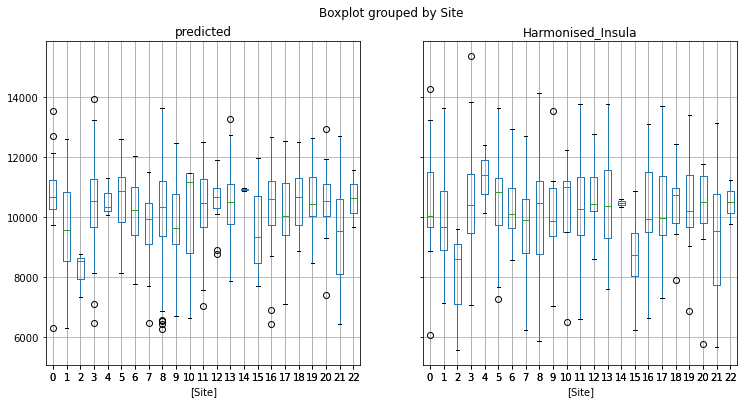

In [57]:
df_xsec.boxplot(['predicted','Harmonised_Insula'],by=['Site'],figsize=(12,6))